Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

NAME = "Anish Yenduri"
NETID = ay559
COLLABORATORS = "NONE"
SOLO PROJECT

---

Final report and CSV Data attached in submission

In [1]:
import sqlite3 #database schema

conn =sqlite3.connect("nba.db")
cursor = conn.cursor()
schema = """
DROP TABLE IF EXISTS predictions;
DROP TABLE IF EXISTS team_season_stats;
DROP TABLE IF EXISTS seasons;
DROP TABLE IF EXISTS teams;


CREATE TABLE    teams (
    team_id    INTEGER PRIMARY KEY,
    team_name    TEXT UNIQUE NOT NULL,
    conference TEXT
);

CREATE TABLE    seasons (
    season_id    INTEGER PRIMARY KEY, 
    season_year   INTEGER UNIQUE NOT NULL
);

CREATE TABLE  team_season_stats (
    team_id     INTEGER NOT NULL,
    season_id   INTEGER NOT NULL,
    wins        INTEGER NOT NULL,
    losses      INTEGER NOT NULL,
    win_pct     REAL NOT NULL,
    field_goal_percentage      REAL,
    three_point_percentage   REAL,
    rebounds         REAL,
    assists         REAL,
    turnovers         REAL,
    points      REAL,
    plus_minus  REAL,
    PRIMARY KEY  (team_id, season_id),
    FOREIGN KEY (team_id) REFERENCES teams(team_id),
    FOREIGN KEY (season_id) REFERENCES seasons(season_id)
);
CREATE TABLE  predictions (
    season_year       INTEGER NOT NULL,
    team_id           INTEGER NOT NULL,
    predicted_win_pct REAL NOT NULL,
    PRIMARY KEY (season_year, team_id),
    FOREIGN KEY (team_id) REFERENCES teams(team_id));

"""
cursor.executescript(schema)
conn.commit()
conn.close()

In [2]:
import sqlite3 #test

conn = sqlite3.connect("nba.db")
cursor = conn.cursor()


cursor.execute( "SELECT name FROM  sqlite_master WHERE  type='table';")
print(cursor.fetchall())

conn.close()


[('teams',), ('seasons',), ('team_season_stats',), ('predictions',)]


In [3]:
#load dataset/ETL
import pandas as pd
df = pd.read_csv("nba_team_stats_00_to_23 (1).csv")

cols = {
    'Team': 'team_name',
    'SEASON': 'season',
    'W': 'wins',
    'L': 'losses',
    'FG%': 'field_goal_percentage',
    '3P%': 'three_point_percentage',
    'TRB': 'rebounds',
    'AST': 'assists',
    'TOV': 'turnovers',
    'PTS': 'points',
    'ORtg': 'ortg',
    'DRtg': 'drtg',
    'NRtg': 'net_rating'
}
df = df.rename( columns=cols)


#check
print(df.columns.tolist())
print(df[['team_name']].head())
print(df['team_name'].isna().sum(), "team_name missing values") 
df['season_year'] = df['season'].astype(str).str.extract(r'(\d{4})').astype(int) 

df['win_pct'] = df['wins'] / (df['wins'] + df['losses'])
df = df.dropna(subset=['win_pct']) 




teams_df = df[['team_name']].drop_duplicates().reset_index(drop=True)
teams_df['team_id'] = teams_df.index + 1  



seasons_df = df[['season_year']].drop_duplicates().reset_index(drop=True)
seasons_df['season_id'] = seasons_df.index + 1

#Merge
df = df.merge(teams_df, on="team_name", how="left")
df = df.merge(seasons_df, on="season_year", how="left")

stats_cols = [
    'wins', 'losses', 'win_pct',
    'field_goal_percentage', 'three_point_percentage',
    'rebounds', 'assists', 'turnovers',
    'points', 'plus_minus'
]


df_fact = df[['team_id', 'season_id'] + stats_cols]
df_fact.head()

['teamstatspk', 'team_name', 'games_played', 'wins', 'losses', 'win_percentage', 'Min', 'points', 'field_goals_made', 'field_goals_attempted', 'field_goal_percentage', 'three_pointers_made', 'three_pointers_attempted', 'three_point_percentage', 'free_throws_made', 'free_throw_attempted', 'free_throw_percentage', 'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists', 'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls', 'personal_fouls_drawn', 'plus_minus', 'season']
                team_name
0          Boston Celtics
1          Denver Nuggets
2   Oklahoma City Thunder
3  Minnesota Timberwolves
4             LA Clippers
0 team_name missing values


,team_id,season_id,wins,losses,win_pct,field_goal_percentage,three_point_percentage,rebounds,assists,turnovers,points,plus_minus
0,1,1,64,18,0.780488,48.7,38.8,3799,2207,979,9887,930
1,2,1,57,25,0.695122,49.6,37.4,3643,2415,1036,9418,431
2,3,1,57,25,0.695122,49.9,38.9,3447,2223,1039,9847,608
3,4,1,56,26,0.682927,48.5,38.7,3577,2184,1162,9264,529
4,5,1,51,31,0.621951,48.9,38.1,3523,2097,1078,9481,269


In [4]:
# Cleaned and renamed columns
# etl pipeline
cols = {
    'Team': 'team_name',
    'SEASON': 'season',
    'W': 'wins',
    'L': 'losses',
    'FG%': 'field_goal_percentage',
    '3P%': 'three_point_percentage',
    'TRB': 'rebounds',
    'AST': 'assists',
    'TOV': 'turnovers',
    'PTS': 'points',
    'ORtg': 'ortg',
    'DRtg': 'drtg',
    'NRtg': 'net_rating'
}
df = df.rename(columns=cols)
print(df.columns.tolist())
print(df[['team_name']].head())
print(df['team_name'].isna().sum(), "team_name missing values")
print(teams_df.head())
print(seasons_df.head())

df['season_year'] = df['season'].astype(str).str.extract(r'(\d{4})').astype(int)

df['win_pct'] = df['wins'] / (df['wins'] + df['losses'])

df = df.dropna(subset=['win_pct'])

teams_df = df[['team_name']].drop_duplicates().reset_index(drop=True)
teams_df['team_id'] = teams_df.index + 1



seasons_df = df[['season_year']].drop_duplicates().reset_index(drop=True)
seasons_df['season_id'] = seasons_df.index + 1

#handled error
df = df.drop(columns=[col for col in df.columns if col.endswith('_x') or col.endswith('_y')], errors='ignore')

df = df.merge(teams_df, on="team_name", how="left")
df = df.merge(seasons_df, on="season_year", how="left")

stats_cols = [
    'wins','losses','win_pct',
    'field_goal_percentage','three_point_percentage',
    'rebounds','assists','turnovers',
    'points','plus_minus'
]
id_cols = {
    'team_id_y': 'team_id',
    'season_id_y': 'season_id'
}

df_fact = df[['team_id_y', 'season_id_y'] + stats_cols]
df_fact = df_fact.rename(columns=id_cols)
df_fact.head()


['teamstatspk', 'team_name', 'games_played', 'wins', 'losses', 'win_percentage', 'Min', 'points', 'field_goals_made', 'field_goals_attempted', 'field_goal_percentage', 'three_pointers_made', 'three_pointers_attempted', 'three_point_percentage', 'free_throws_made', 'free_throw_attempted', 'free_throw_percentage', 'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists', 'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls', 'personal_fouls_drawn', 'plus_minus', 'season', 'season_year', 'win_pct', 'team_id', 'season_id']
                team_name
0          Boston Celtics
1          Denver Nuggets
2   Oklahoma City Thunder
3  Minnesota Timberwolves
4             LA Clippers
0 team_name missing values
                team_name  team_id
0          Boston Celtics        1
1          Denver Nuggets        2
2   Oklahoma City Thunder        3
3  Minnesota Timberwolves        4
4             LA Clippers        5
   season_year  season_id
0         2023          1
1    

,team_id,season_id,wins,losses,win_pct,field_goal_percentage,three_point_percentage,rebounds,assists,turnovers,points,plus_minus
0,1,1,64,18,0.780488,48.7,38.8,3799,2207,979,9887,930
1,2,1,57,25,0.695122,49.6,37.4,3643,2415,1036,9418,431
2,3,1,57,25,0.695122,49.9,38.9,3447,2223,1039,9847,608
3,4,1,56,26,0.682927,48.5,38.7,3577,2184,1162,9264,529
4,5,1,51,31,0.621951,48.9,38.1,3523,2097,1078,9481,269


In [5]:
#insert into SQLite
conn = sqlite3.connect("nba.db")
teams_df.to_sql("teams", conn, if_exists="replace", index=False)
seasons_df.to_sql("seasons", conn, if_exists="replace", index=False)
df_fact.to_sql("team_season_stats", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

In [6]:
#check if it works
conn = sqlite3.connect("nba.db")
import pandas as pd

print("Rows:")
for table in ["teams", "seasons", "team_season_stats"]  :
    
    print(table, pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", conn)["n"][0])

print("\npreview:")
preview = pd.read_sql("""

SELECT t.team_name, s.season_year, ts.win_pct
FROM team_season_stats ts
JOIN teams t ON ts.team_id = t.team_id
JOIN seasons s ON ts.season_id = s.season_id
LIMIT 10;
""", conn )

conn.close()
preview


Rows:
teams 37
seasons 24
team_season_stats 716

preview:


,team_name,season_year,win_pct
0,Boston Celtics,2023,0.780488
1,Denver Nuggets,2023,0.695122
2,Oklahoma City Thunder,2023,0.695122
3,Minnesota Timberwolves,2023,0.682927
4,LA Clippers,2023,0.621951
5,Dallas Mavericks,2023,0.609756
6,New York Knicks,2023,0.609756
7,Milwaukee Bucks,2023,0.597561
8,New Orleans Pelicans,2023,0.597561
9,Phoenix Suns,2023,0.597561


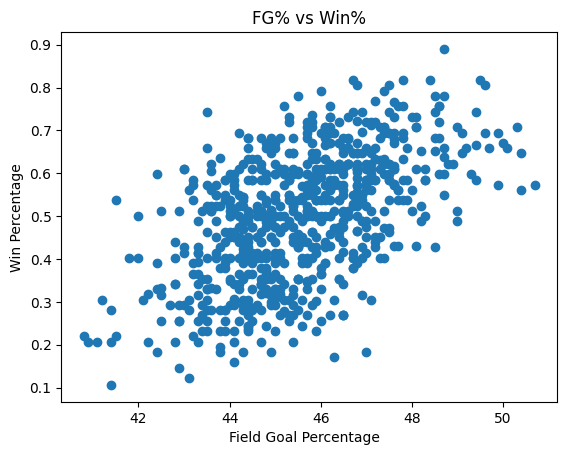

In [7]:
#visualization looking at fg vs win pct
import matplotlib.pyplot as plt
plt.scatter(df['field_goal_percentage'], df['win_pct'])
plt.xlabel("Field Goal Percentage  ")
plt.ylabel("Win Percentage")
plt.title("FG% vs Win%")
plt.show()

In [8]:
#sql queries
conn = sqlite3.connect("nba.db")
top10 = """
SELECT t.team_name, s.season_year, f.win_pct
FROM team_season_stats f
JOIN teams t ON f.team_id = t.team_id
JOIN seasons s ON f.season_id = s.season_id
ORDER BY f.win_pct DESC
LIMIT 10; 

"""

pd.read_sql(top10, conn)



,team_name,season_year,win_pct
0,Golden State Warriors,2015,0.890244
1,Golden State Warriors,2016,0.817073
2,San Antonio Spurs,2015,0.817073
3,Golden State Warriors,2014,0.817073
4,Dallas Mavericks,2006,0.817073
5,Miami Heat,2012,0.804878
6,Cleveland Cavaliers,2008,0.804878
7,Boston Celtics,2007,0.804878
8,Houston Rockets,2017,0.792683
9,Los Angeles Lakers,2008,0.792683


In [9]:
avg_by_season = """

SELECT s.season_year, AVG(f.win_pct) AS avg_win_pct
FROM team_season_stats f
JOIN seasons s ON f.season_id = s.season_id
GROUP BY s.season_year
ORDER BY s.season_year;
"""

pd.read_sql(avg_by_season,conn)

,season_year,avg_win_pct
0,2000,0.500000
1,2001,0.500000
2,2002,0.500000
3,2003,0.500000
4,2004,0.500000
5,2005,0.500000
6,2006,0.500000
7,2007,0.500000
8,2008,0.500000
9,2009,0.500000


In [10]:
turnovers = """

SELECT 
    CASE 
        WHEN win_pct >= 0.60 THEN 'Top (≥60%)'
        WHEN win_pct <= 0.40 THEN 'Bottom (≤40%)'
        ELSE 'Middle'
    END AS tier,
    COUNT(*) AS num_teams,
    AVG(turnovers) AS avg_turnovers
FROM team_season_stats
GROUP BY tier;
"""

pd.read_sql(turnovers,conn)

,tier,num_teams,avg_turnovers
0,Bottom (≤40%),182,1204.016484
1,Middle,337,1148.252226
2,Top (≥60%),197,1121.345178


In [ ]:
#other visualizations
plt.scatter(df["three_point_percentage"],  df["win_pct"])
plt.xlabel("3-Point Percentage")
plt.ylabel("Win Percentage")
plt.title("3P% vs Win%")
plt.grid(True)
plt.show()

plt.scatter(df["turnovers"], df["win_pct"])
plt.xlabel("Turnovers")
plt.ylabel("Win Percentage")
plt.title("Turnovers vs Win%")
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
correlation = df[["win_pct", "field_goal_percentage", "three_point_percentage",
           "rebounds", "assists", "turnovers", "points", "plus_minus"]].corr()


plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap")
plt.show()

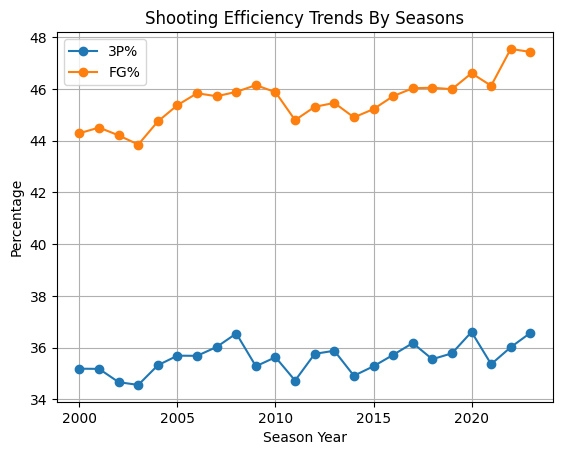

In [13]:
trend_df = df.groupby("season_year")[["three_point_percentage", "field_goal_percentage"]].mean()
plt.plot(trend_df.index, trend_df["three_point_percentage"], marker='o', label="3P%")
plt.plot(trend_df.index, trend_df["field_goal_percentage"], marker='o', label="FG%")
plt.xlabel("Season Year")
plt.ylabel("Percentage")
plt.title("Shooting Efficiency Trends By Seasons")


plt.legend()
plt.grid(True)
plt.show()

Linear Regression R^2: 0.901019140009148
Linear Regression MAE: 0.033890573637842286
Random Forest R^2: 0.9003425029418093
Random Forest MAE: 0.036004938157546504


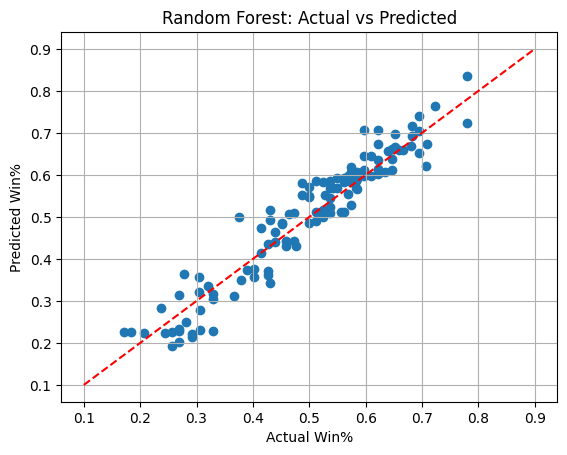

,team_name,win_pct,predicted_win_pct
0,Boston Celtics,0.780488,0.836559
2,Oklahoma City Thunder,0.695122,0.741173
3,Minnesota Timberwolves,0.682927,0.717317
1,Denver Nuggets,0.695122,0.652104
6,New York Knicks,0.609756,0.646200
8,New Orleans Pelicans,0.597561,0.644634
11,Indiana Pacers,0.573171,0.617824
4,LA Clippers,0.621951,0.613298
7,Milwaukee Bucks,0.597561,0.611384
14,Philadelphia 76ers,0.573171,0.606134


In [14]:
#ML Training

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error





features= [ "field_goal_percentage", "three_point_percentage","rebounds", "assists", "turnovers", "points", "plus_minus" ] 
target = "win_pct"

train = df[df["season_year"] <= 2017]
validate = df[(df["season_year"] >= 2018) & (df["season_year"] <= 2019)]
test = df[df["season_year"] >= 2020]
X_train, y_train = train[features], train[target]
X_val, y_val = validate[features], validate[target]
X_test, y_test = test[features], test[target] 

#Lin Reg

linReg = LinearRegression()
linReg.fit(X_train, y_train)

pred_test_linReg =linReg.predict(X_test)

print("Linear Regression R^2:", r2_score(y_test, pred_test_linReg))
print("Linear Regression MAE:", mean_absolute_error(y_test, pred_test_linReg))

pd.DataFrame({"feature": features, "coef": linReg.coef_})

#random forest

randForest = RandomForestRegressor(n_estimators=400, random_state=42)
randForest.fit(X_train, y_train)

pred_test = randForest.predict(X_test)

print("Random Forest R^2:", r2_score(y_test, pred_test))
print("Random Forest MAE:", mean_absolute_error(y_test, pred_test))

pd.DataFrame({"feature": features, "importance": randForest.feature_importances_}).sort_values("importance", ascending=False)




plt.scatter(y_test, pred_test)
plt.xlabel("Actual Win%")
plt.ylabel("Predicted Win%")
plt.title("Random Forest: Actual vs Predicted")
plt.plot([0.1, .9], [0.1, .9], 'r--')
plt.grid(True)
plt.show()

current = df["season_year"].max() #data has 2023 as current season, not 2025
future= df[df["season_year"] ==current].copy()
future["predicted_win_pct"] = randForest.predict(future[features])
future[["team_name", "win_pct", "predicted_win_pct"]].sort_values("predicted_win_pct", ascending=False)
#checks if a team performed like it did in 2023, what would its win percentage be in the next year